In [1]:
# import necessary libraries and files

import os
import matplotlib.pyplot as plt

from project_functions import *
from skimage.morphology import remove_small_objects, remove_small_holes, closing, disk

In [2]:
# PATH DEF
path_to_ref = "./dataset/references"
path_to_train = "./dataset/train"
path_to_test = "./dataset/test"

path_to_labels = "./dataset/train.csv"
path_to_submission = "./dataset/sample_submission.csv"

assert os.path.exists(path_to_ref), "ERROR: references folder not found"
assert os.path.exists(path_to_train), "ERROR: train folder not found"
assert os.path.exists(path_to_test), "ERROR: test folder not found"
assert os.path.exists(path_to_labels), "ERROR: labels for training not found"
assert os.path.exists(path_to_submission), "ERROR: submission file not found"

# CHOCO TYPES
amandina = "1. Amandina"
arabia = "2. Arabia"
comtesse = "3. Comtesse"
creme_brulee = "4. Crème brûlée"
jelly_black = "5. Jelly black"
jelly_milk = "6. Jelly milk"
jelly_white = "7. Jelly white"
noblesse = "8. Noblesse"
noir_authentique = "9. Noir authentique"
passion_lait = "10. Passion au lait"
stracciatella = "11. Stracciatella"
tentation_noir = "12. Tentation noir"
triangolo = "13. Triangolo"

In [3]:
# LOADING DATA

ref_img = np.load("ref_images.npy")

train_data = np.load("train_data.npz")
train_img = train_data["images"]
train_labels = train_data["labels"]

test_img= np.load("test_images.npy")

# train_img = np.load("test_images.npy")

In [4]:
ref_img.shape

(13, 4000, 6000, 3)

In [5]:
print(train_labels.shape)
print(train_img.shape)

(90, 13)
(90, 4000, 6000, 3)


# 1) Preprocessing & Segmentation

# What are we doing to obtain the masks/contours
The biggest problem is the big variety between all the chocolates. We could think that detecting/masking them could be done through edge detection, however due to multiple factors (image quality, shadows, reflections and chocolate colours) such a method does not give reliable results. 

For that reason our goal is to create, for the moment, a mask that should be capable of highlighting the rough shape of all chocolate types.

For the moment we are at the plain background which can cause a lot of noise into the image. To avoid this troubling us, we will try and remove it as much as possible. To do this we use :
    Gaussian blur to smooth over full image and remove this from the original which immediatly removes alotof homogeneity from the background. and leaves only elements that show more detail.

After this CLAHE is applied. To increase local contrast (help with edge detection with areas that are not very clear)

Multiple morphological transformations are then applied to enhanced desired elements and reduce any noise coming from the image or previous processes.

These are then thresholded to have a binary image on which further morphology processes are applied to have a mask that covers the area of the chocolate as best as possible.

Also saw this:
https://docs.opencv.org/3.4/d2/dbd/tutorial_distance_transform.html 



!!! Comtesse appears to not be a complete mask and bad contour. Am still testing more transforms to have good results for it.

In [6]:
square = np.ones((5, 5), dtype=np.uint8)

def filter_small_components(binary, min_area=175):
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary, connectivity=8)
    large_components = [i for i in range(1, num_labels) if stats[i, cv2.CC_STAT_AREA] >= min_area]
    mask = np.isin(labels, large_components).astype(np.uint8) * 255
    return mask

def multi_dil(im, num, element=square):
    return cv2.dilate(im, element, iterations=num)

def multi_ero(im, num, element=square):
    return cv2.erode(im, element, iterations=num)

def morph_open_and_close_pipeline(img_rgb):
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    bg = cv2.GaussianBlur(gray, (51, 51), 0)
    corrected = cv2.subtract(gray, bg)

    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(16, 16))
    contrast = clahe.apply(corrected)

    # Reuse kernels
    kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
    kernel_close1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (31, 31))
    kernel_close2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (37, 37))
    kernel_noise_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
    kernel_close_final = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (251, 251))

    opened = cv2.morphologyEx(contrast, cv2.MORPH_OPEN, kernel_open)
    closed1 = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel_close1)
    closed2 = cv2.morphologyEx(closed1, cv2.MORPH_CLOSE, kernel_close2)
    cleaned = cv2.morphologyEx(closed2, cv2.MORPH_OPEN, kernel_noise_open)

    _, binary = cv2.threshold(cleaned, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary_filtered = filter_small_components(binary, min_area=175)

    multi_dilated = multi_dil(binary_filtered, 10)
    closed = cv2.morphologyEx(multi_dilated, cv2.MORPH_CLOSE, kernel_close_final)
    closed = cv2.morphologyEx(closed, cv2.MORPH_CLOSE, kernel_close_final)

    # area_closed = area_closing(closed, area_threshold=80000)  # optional to replace
    multi_eroded = multi_ero(closed, 7)
    reconnected = cv2.dilate(multi_eroded, square, iterations=1)
    closed3 = cv2.morphologyEx(reconnected, cv2.MORPH_OPEN, square)

    return contrast, binary, closed3

def show_results(contrast, binary, filtered):
    plt.figure(figsize=(15, 4))
    titles = ["CLAHE Contrast", "Otsu Binary", "Final Filtered"]
    images = [contrast, binary, filtered]
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

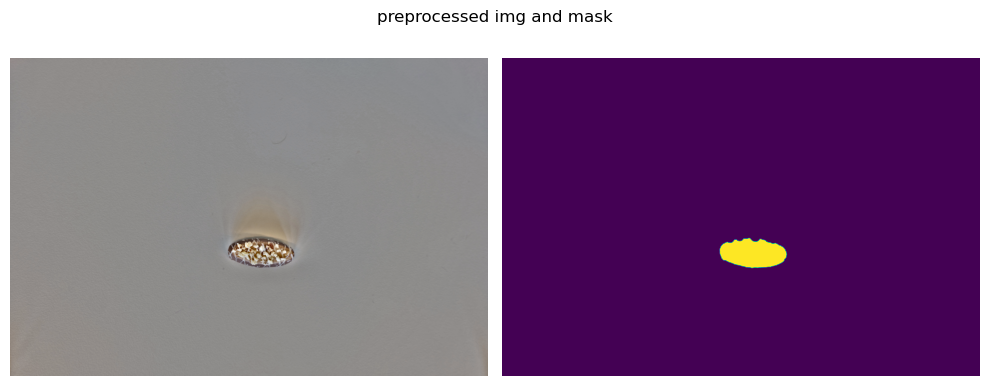

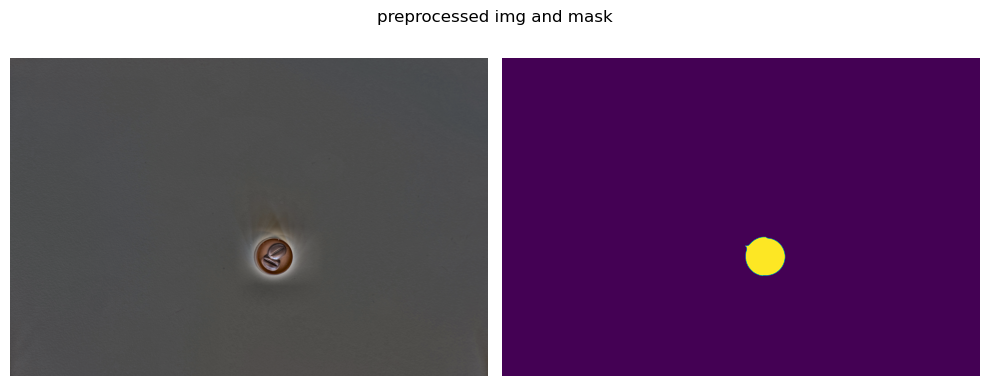

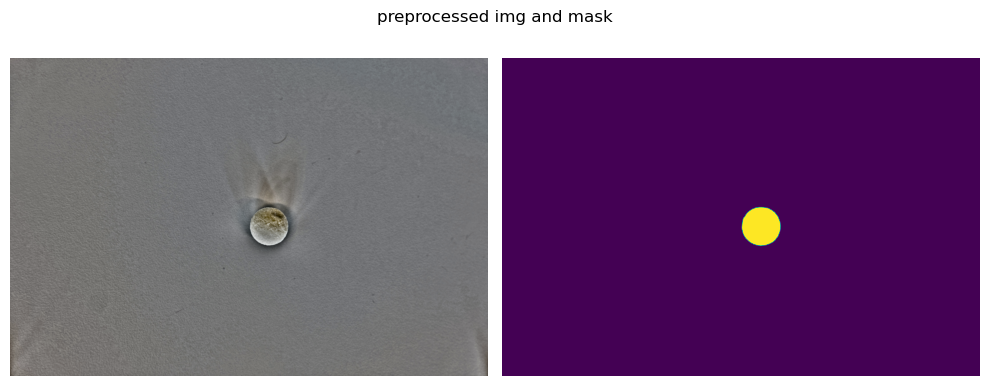

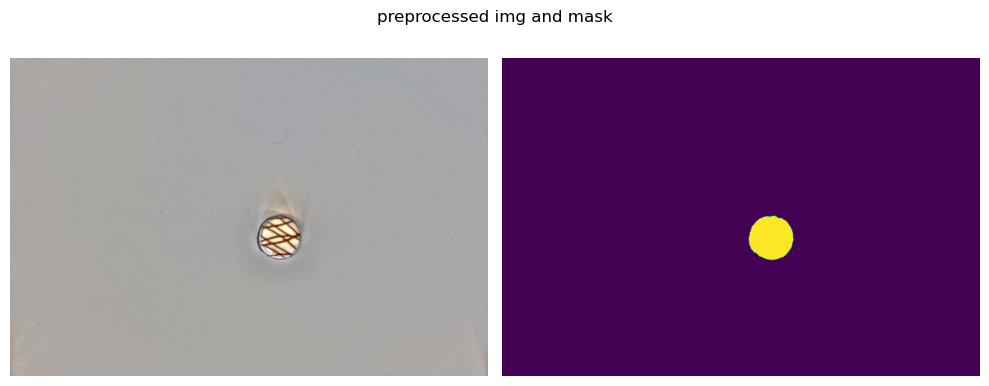

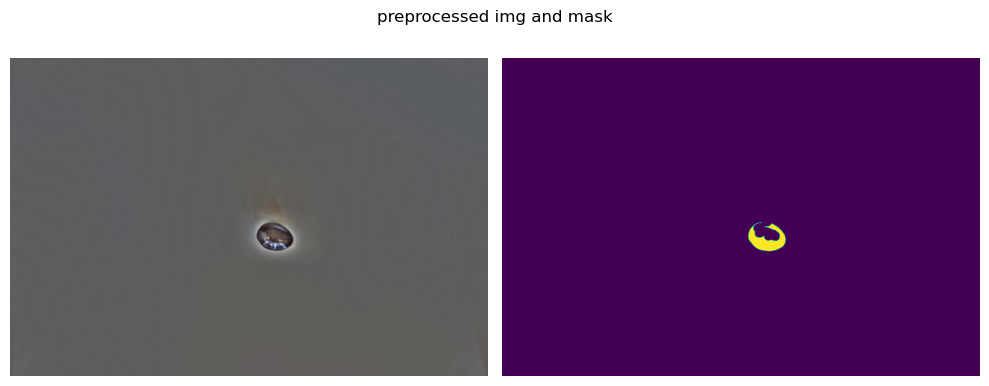

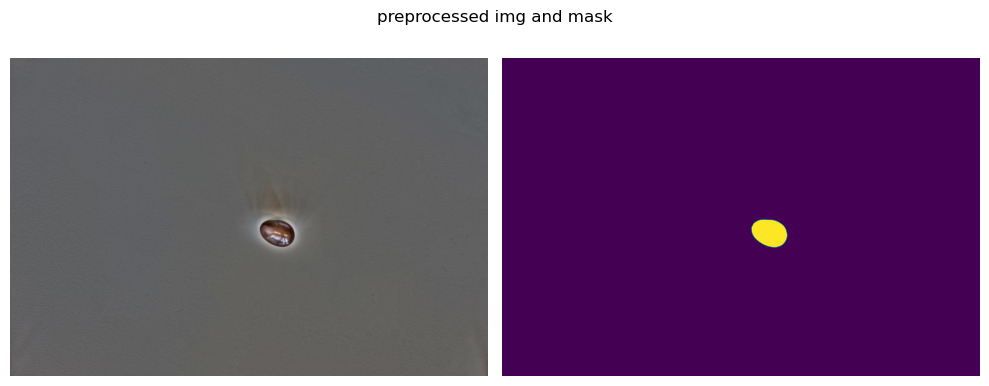

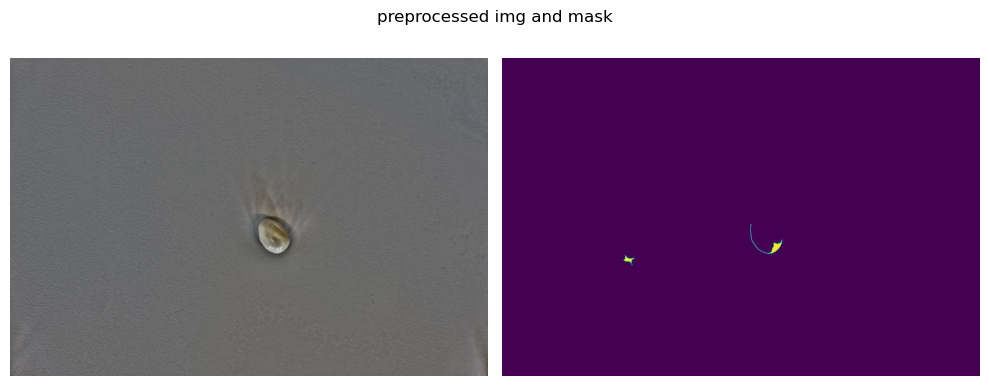

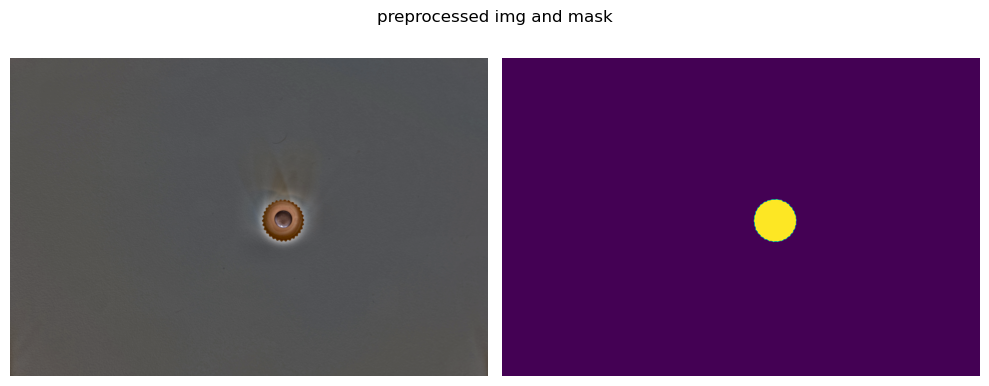

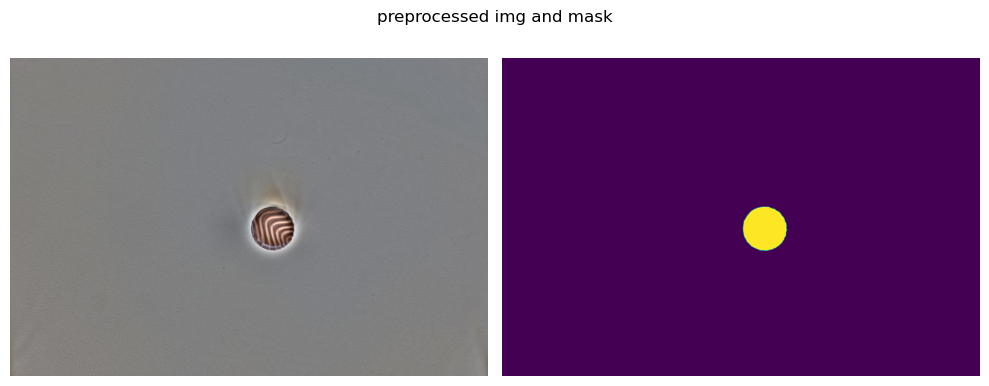

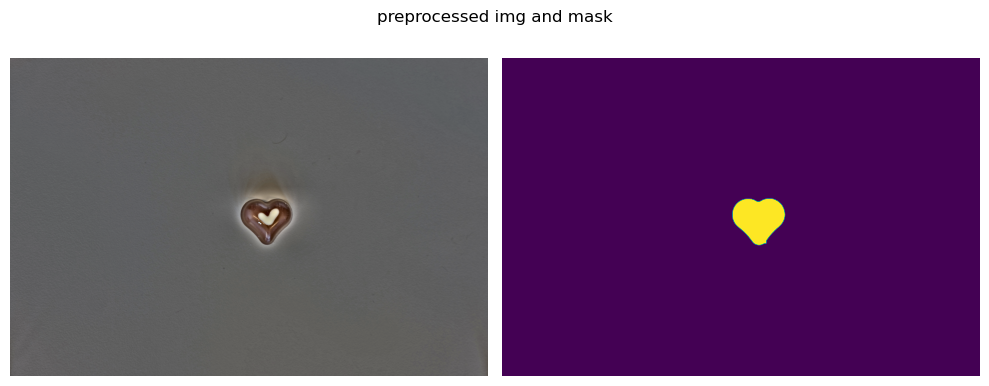

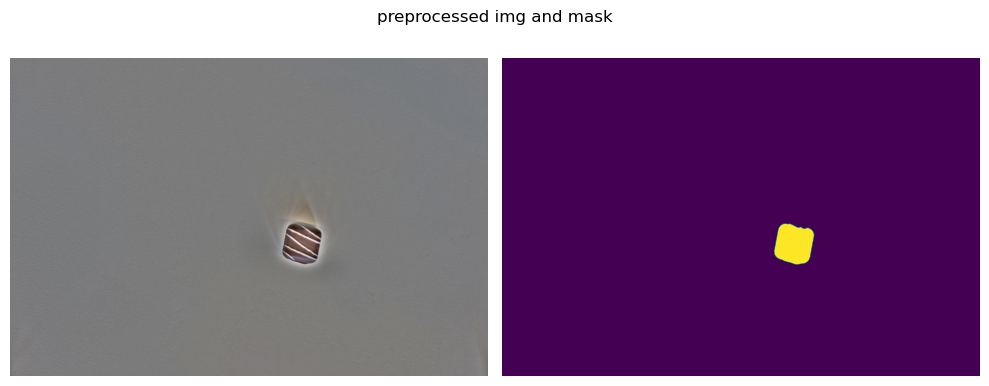

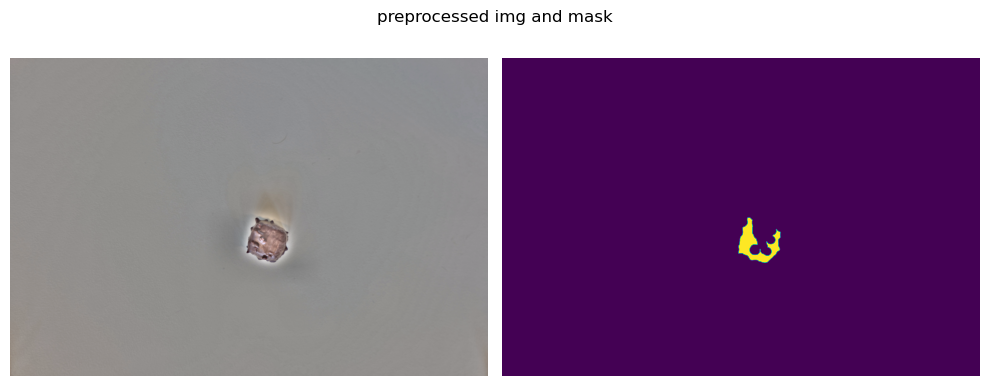

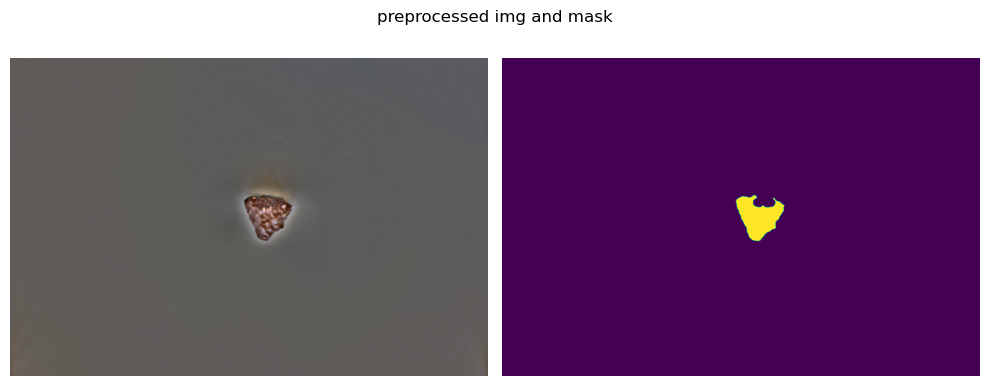

In [7]:
final_masks = []

for idx, img in enumerate(ref_img):
    preprocessed_img, edge_mask = preprocessing(img)
    final_masks.append(edge_mask)
    plot_image_comparison(preprocessed_img, edge_mask, "preprocessed img and mask")

# 2) Objects description

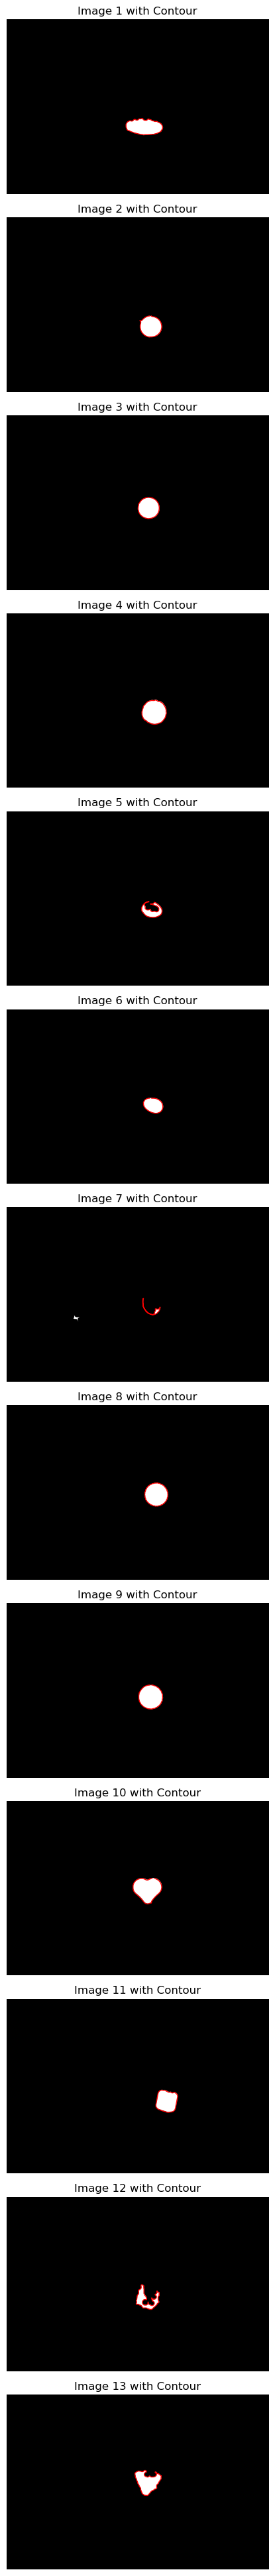

In [8]:
# Find contour

contours = find_all_contours(final_masks)

plot_contour_batch(final_masks, contours)

In [9]:
# Region-based descriptors

all_region_descriptors = compute_all_region_descriptors(final_masks)

In [10]:
# Fourier descriptors

all_fourier_desc = compute_descriptor_interpolated(contours, 13)

# Check Fourier descriptors

#xs, ys = compute_reverse_descriptors(all_fourier_desc, n_samples=13)
#plot_fourier_reconstructions(contours, xs, ys)

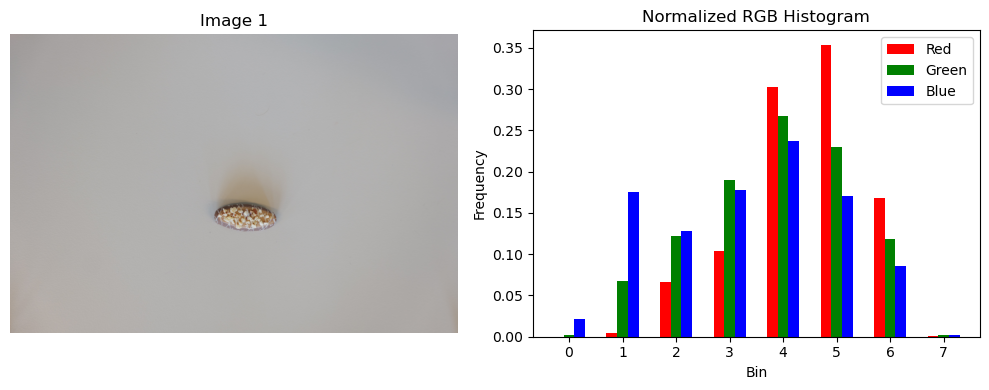

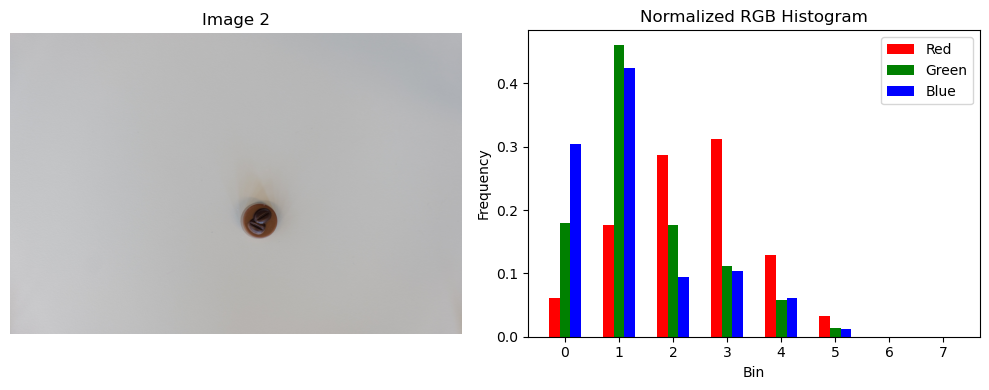

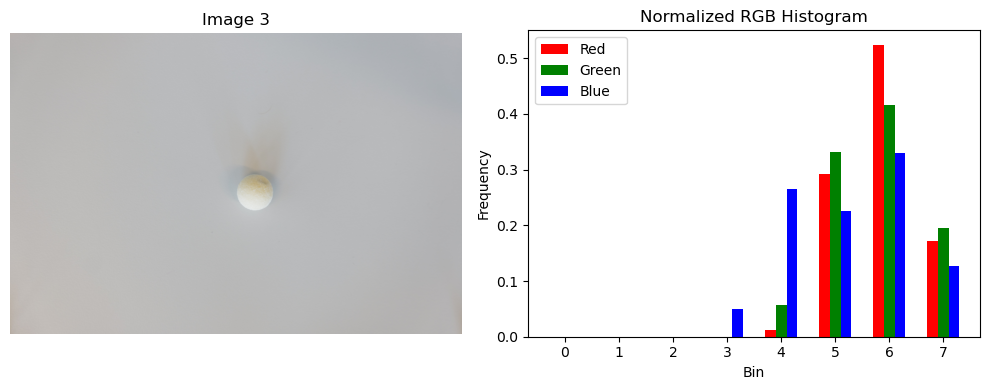

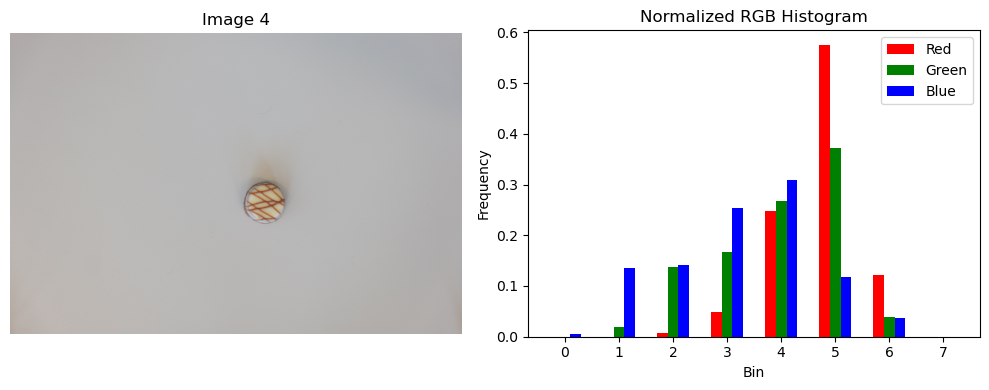

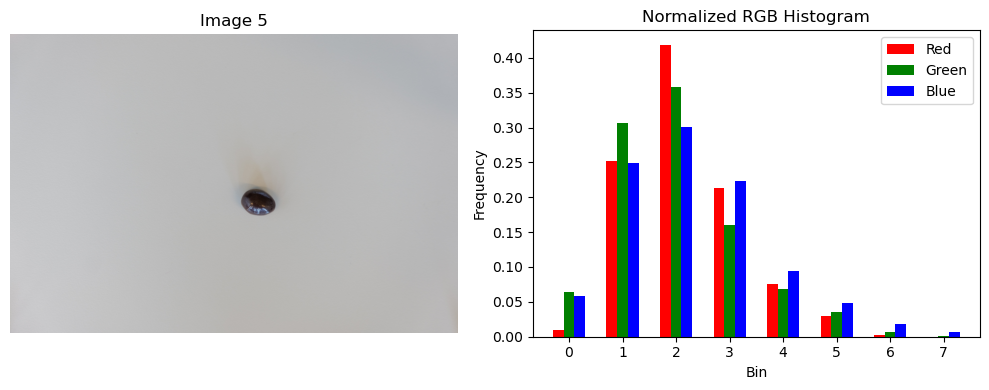

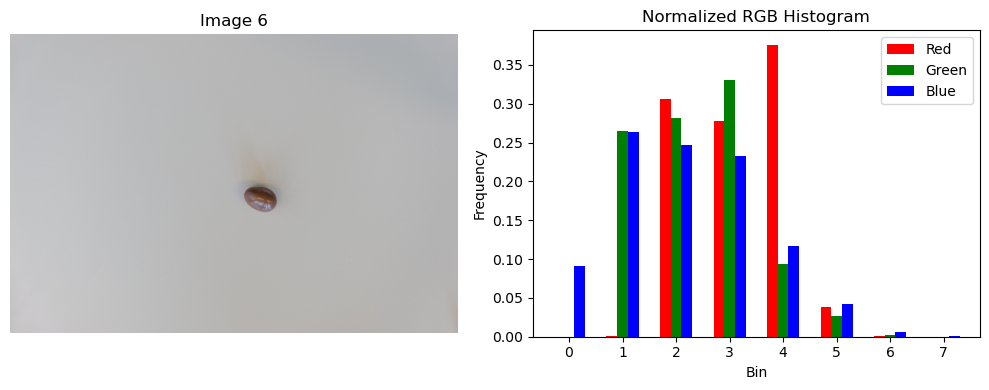

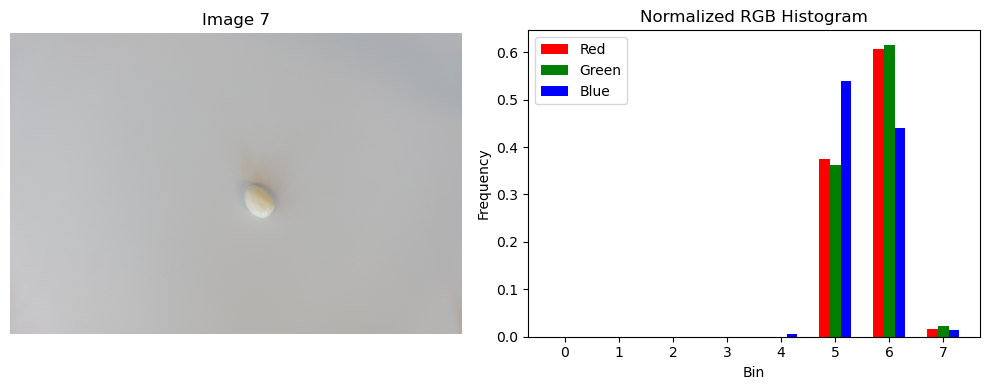

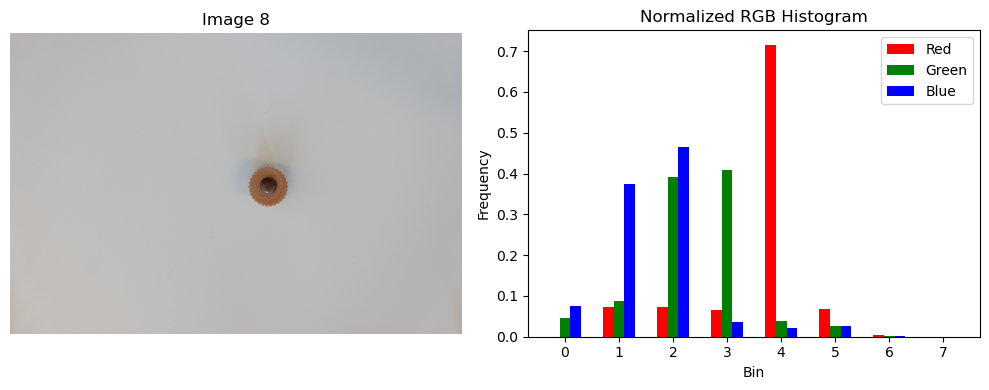

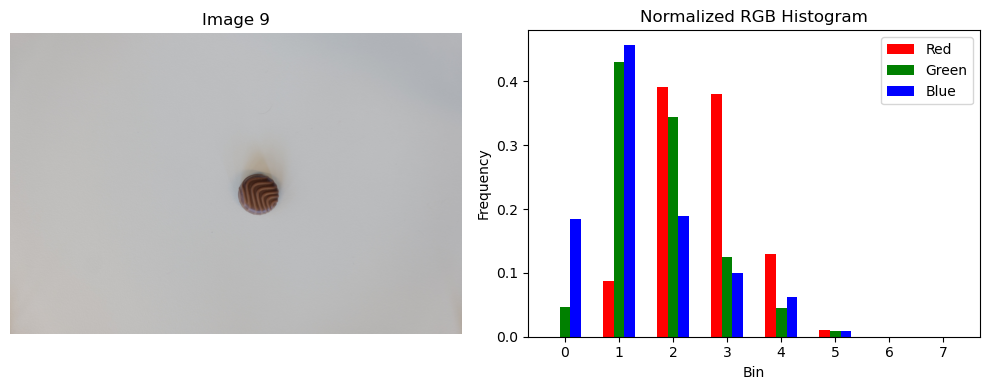

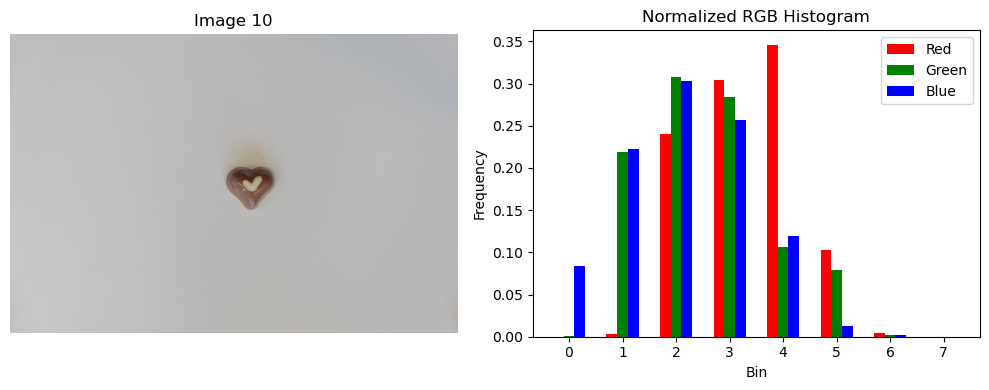

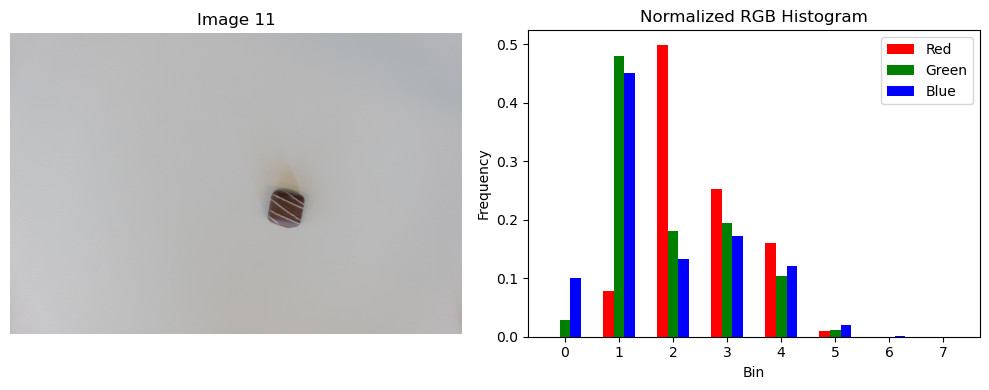

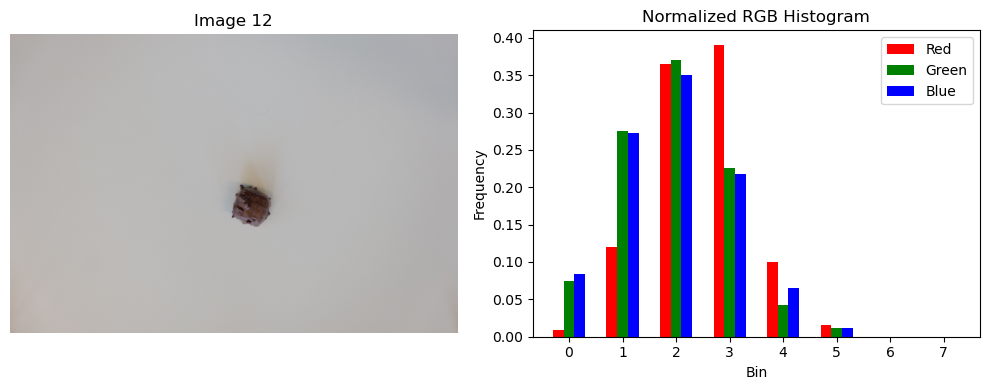

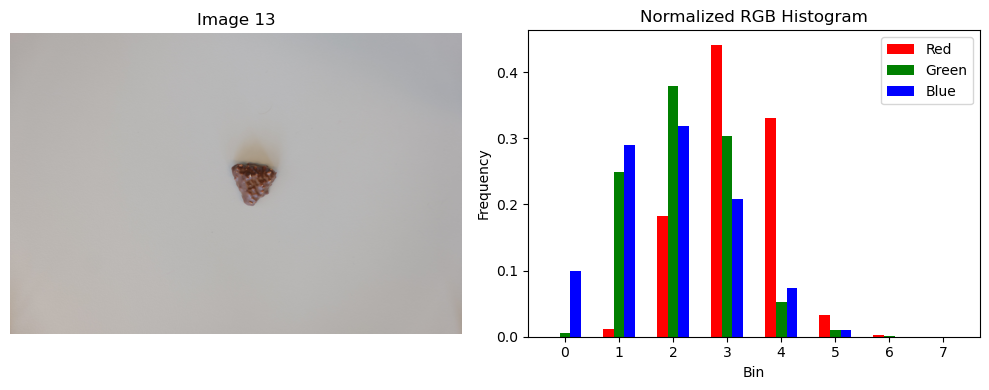

In [11]:
# Color-based descriptors

color_means_and_stds, color_hists = color_descriptors(ref_img, final_masks)

show_rgb_histograms(ref_img, color_hists)

c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


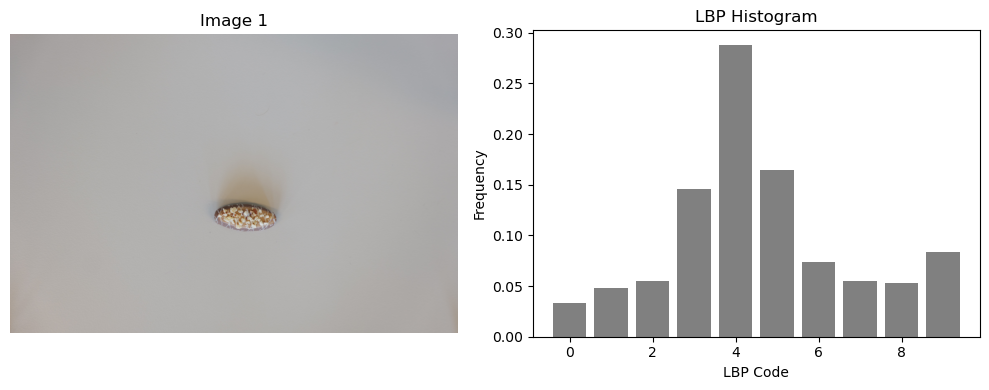

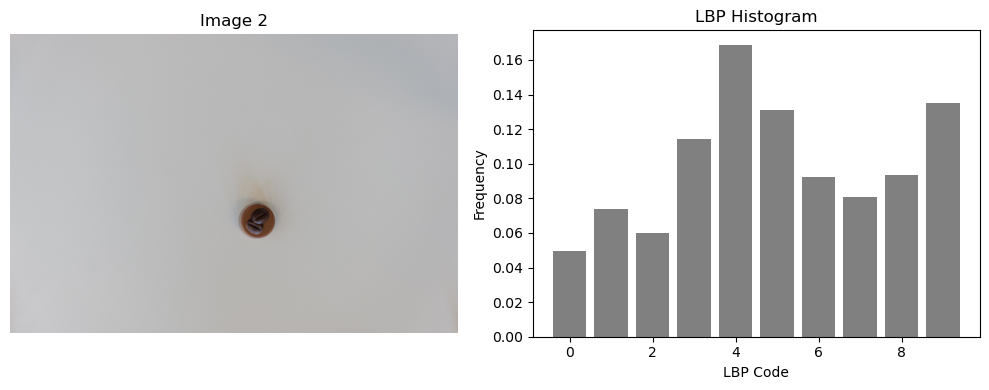

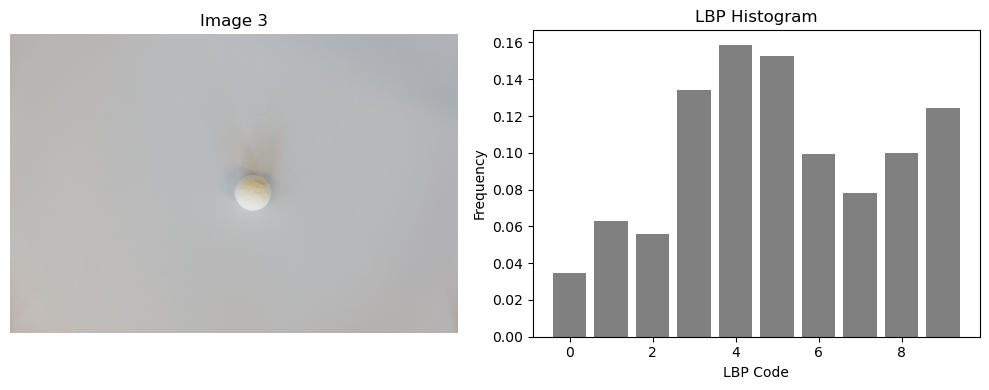

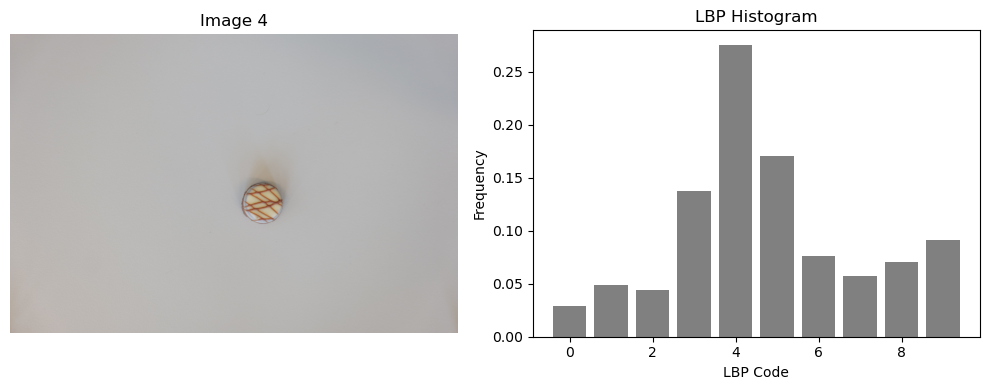

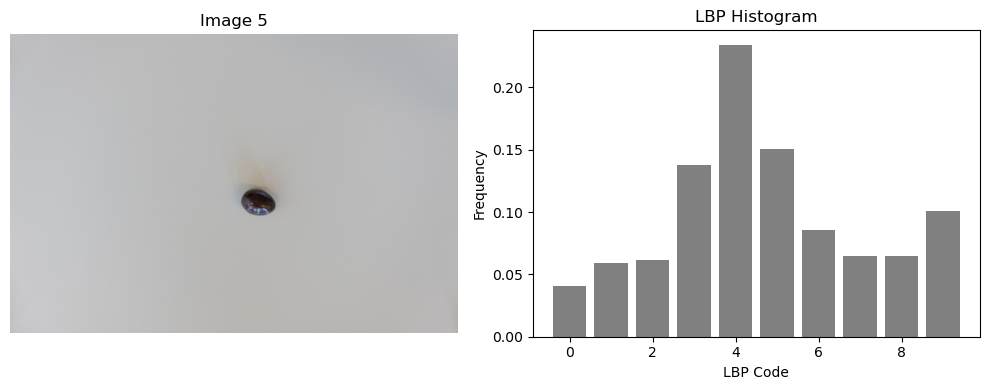

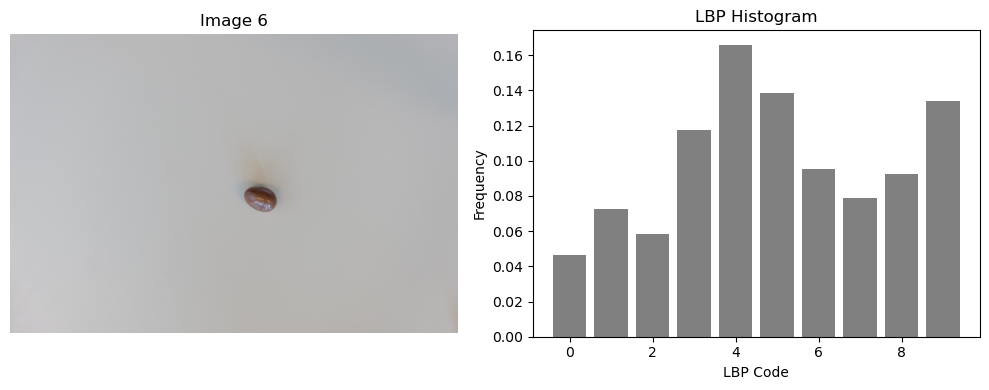

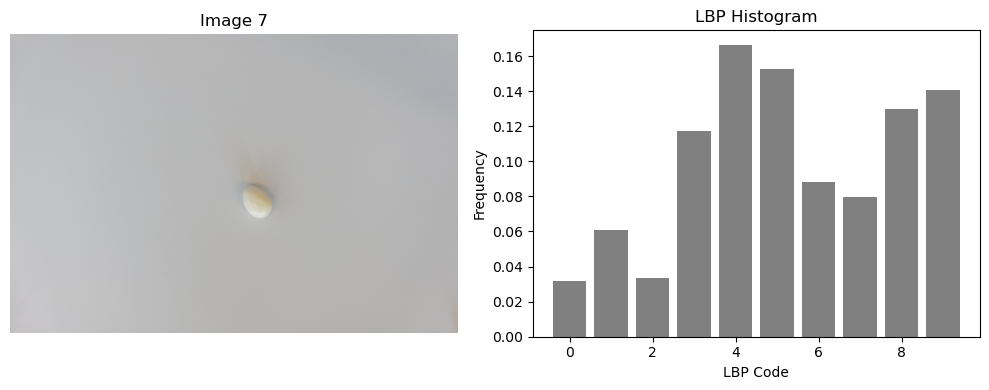

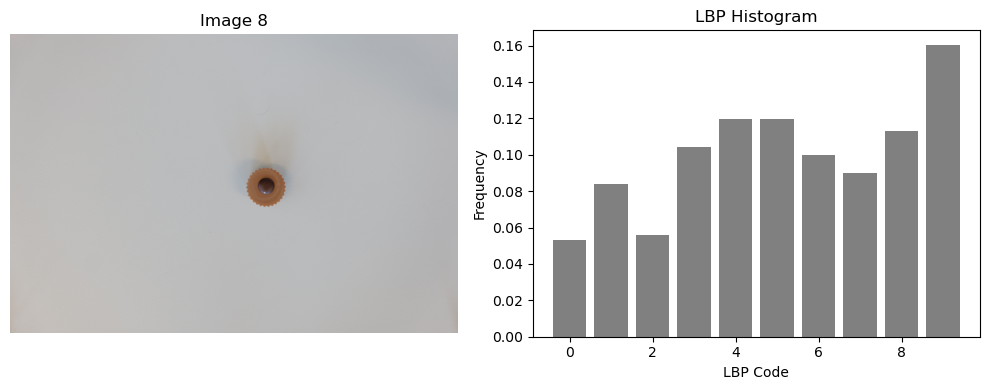

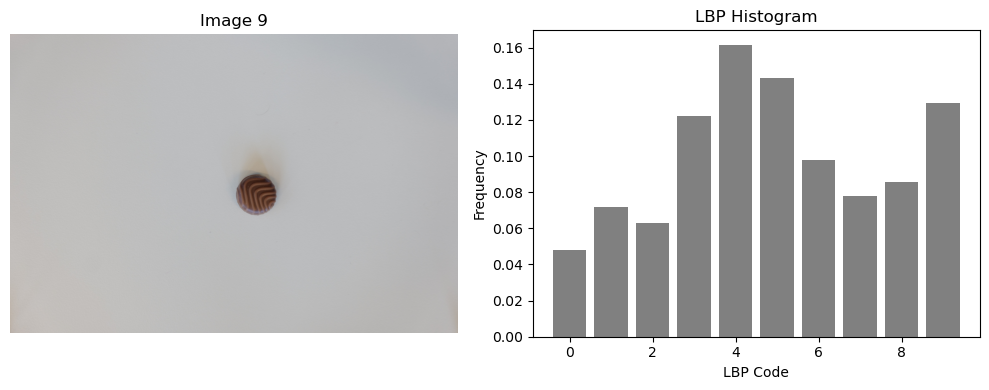

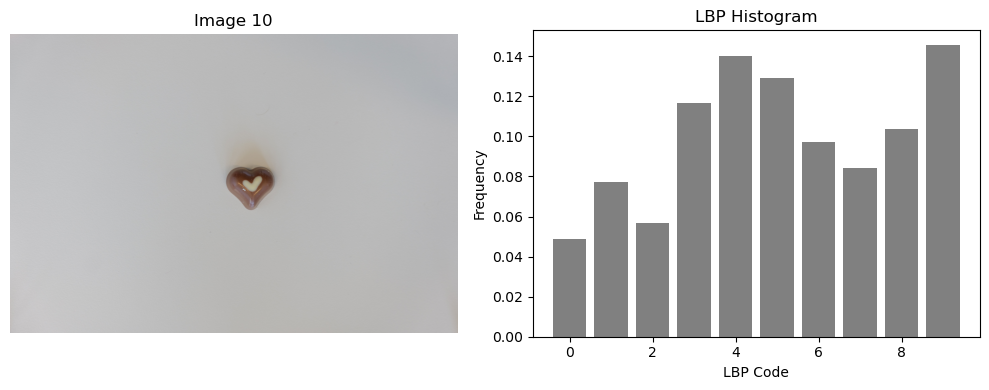

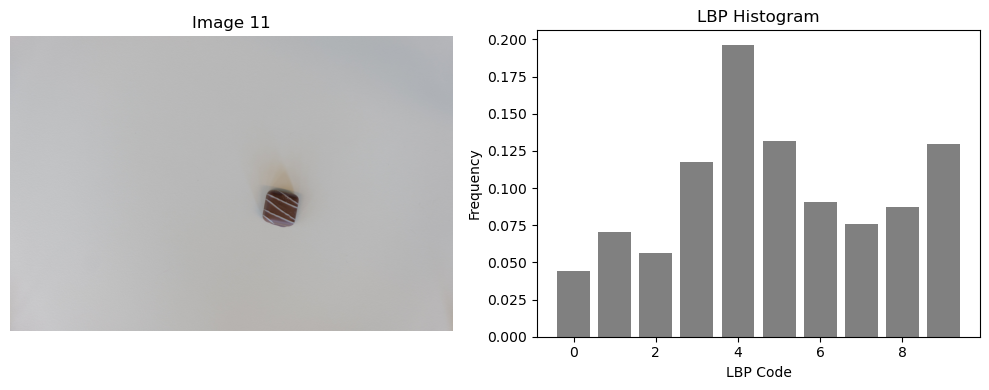

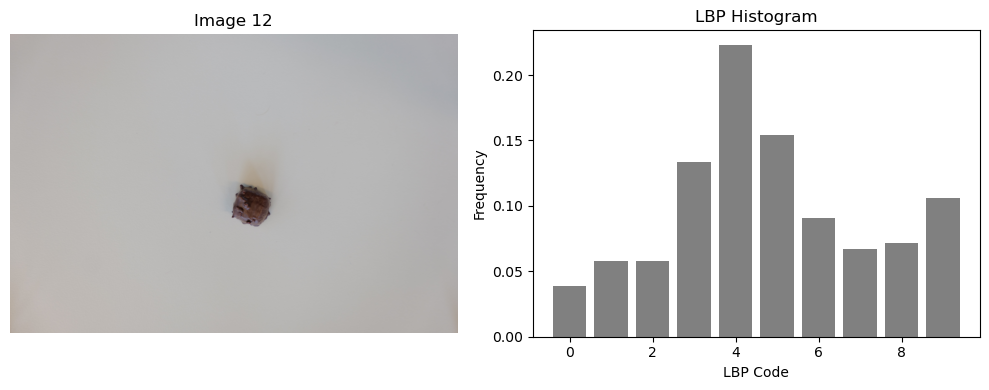

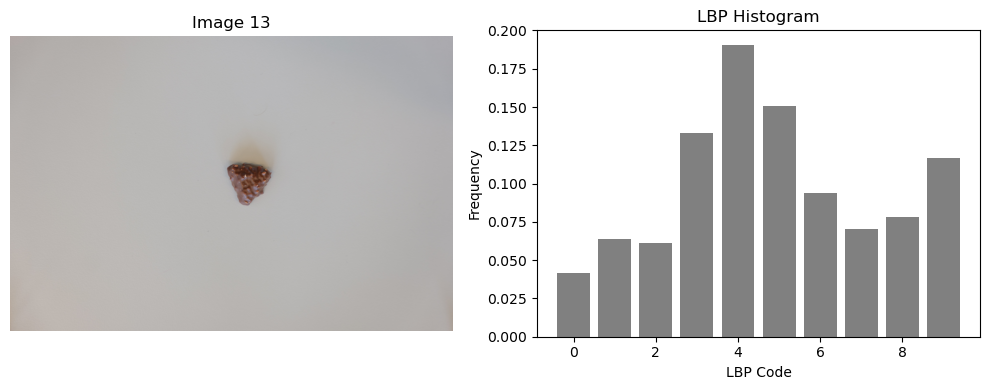

In [12]:
# LBP histogram as descriptor

lbp_hists = lbp_histograms(ref_img, final_masks)

# Check LBP histograms

show_lbp_histograms(ref_img, lbp_hists)

In [13]:
# Concatenate all features

features_ref = concatenate_descriptors_batch(all_region_descriptors, all_fourier_desc, color_descs=color_means_and_stds, color_hists=color_hists, lbps=lbp_hists)

print(features_ref.shape)

(13, 63)


## --- BACKGROUND CALIBRATION ---

6 ≠ backgrounds --> ref from training set for each bg type:

- BLANK TABLE: [0]
- ORANGE BOOK: [102]
- WHITE AND BLUE BOX FOR PENS: [103]
- BOX WITH PEACOCKS: [104]
- TOTE BAG: [106]
- JELLY PACKAGE: [108]

/!\ BACKGROUNDS ARE ROTATED /!\

In [14]:
blank_table_img = train_img[0]
orange_book_img = train_img[30]
w_b_box_img = train_img[31]
peacock_box_img = train_img[32]
tote_bag_img = train_img[37]
jelly_pack_img = train_img[39]

In [15]:
from sklearn.cluster import KMeans
from scipy.linalg import inv
import pickle

# ----------------------- hyper-parameters ----------------------- #
DOWNSAMPLE = 0.2                 # resize factor 1/5
PATCH = 64                       # training patch size
CORNER = 64                      # inference patch size
LBP_P, LBP_R = 8, 1              # uniform LBP (59 bins)
N_BINS_H = 8                     # hue histogram bins
K_BG = 6                         # number of background types
TH_TEX, TH_CHR = 1.0, 5.0
STRIDE = 64                     # non-overlapping patches (jump of pixels)
# ---------------------------------------------------------------- #

def hue_hist(img_hsv):
    """8-bin normalised histogram of the H channel."""
    h = img_hsv[..., 0].ravel()
    hist, _ = np.histogram(h, bins=N_BINS_H, range=(0, 180), density=True)
    return hist.astype(np.float32)

def lbp_hist(rgb: np.ndarray, mask: np.ndarray, P: int = 8, R: float = 1.0,
             method: str = "uniform"):
    """Rotation-invariant LBP histogram inside the mask.

    Parameters
    ----------
    P, R : classical LBP neighbourhood parameters.
    method : 'uniform' gives (P+2) unique codes.

    Returns
    -------
    hist : 1D float array, length depends on method (for 'uniform', P+2).
    """
    gray = rgb2gray(rgb)
    lbp = local_binary_pattern(gray, P=P, R=R, method=method)
    lbp = lbp[mask > 0]
    n_bins = int(lbp.max()) + 1
    hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins), density=False)
    hist = hist.astype(float)
    hist /= hist.sum() + 1e-12
    return hist

def descriptor(patch_bgr):
    hsv = cv2.cvtColor(patch_bgr, cv2.COLOR_BGR2HSV)
    lab = cv2.cvtColor(patch_bgr, cv2.COLOR_BGR2LAB)
    # 8-bin Hue hist
    h_hist, _ = np.histogram(hsv[...,0], bins=8, range=(0,180), density=True)
    # rot-inv uniform LBP (59 bins) on L
    lbp = local_binary_pattern(lab[...,0], LBP_P, LBP_R, method="uniform")
    n_bins = int(lbp.max()+1)
    lbp_hist, _ = np.histogram(lbp, bins=n_bins, range=(0,n_bins), density=True)
    return np.hstack([h_hist, lbp_hist]).astype(np.float32)

def collect_descriptors(train_root):
    img_descs, patch_imgs, gallery = [], [], []
    
    for img_path in Path(train_root).glob("*.JPG"):
        img = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
        if img is None:
            print(f"can't read {img_path}")
            continue

        # shrink to suppress the chocolates
        h0, w0 = img.shape[:2]
        scale  = max(PATCH / min(h0, w0), DOWNSAMPLE)
        small = cv2.resize(img, None, fx=scale, fy=scale,
                           interpolation=cv2.INTER_AREA)
        lab = cv2.cvtColor(small, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        grad = cv2.Sobel(l, cv2.CV_32F, 1, 1, ksize=3)   # texture proxy

        patch_descs, patch_scores = [], []
        for y in range(0, lab.shape[0]-PATCH+1, STRIDE):
            for x in range(0, lab.shape[1]-PATCH+1, STRIDE):
                sub_l = l[y:y+PATCH, x:x+PATCH]
                sub_g = grad[y:y+PATCH, x:x+PATCH]
                sub_a = a[y:y+PATCH, x:x+PATCH]
                sub_b = b[y:y+PATCH, x:x+PATCH]

                tex = sub_g.var()
                chroma = np.sqrt(sub_a.mean()**2 + sub_b.mean()**2)
                all_tex = np.array(tex)
                all_chroma = np.array(chroma)
                t_tex = np.percentile(all_tex, 30)
                t_chr = np.percentile(all_chroma, 30)
                if tex < t_tex and chroma < t_chr:        # likely white table
                    continue
                patch = small[y:y + PATCH, x:x + PATCH]
                patch_descs.append(descriptor(patch))
                patch_scores.append(tex + chroma)
                patch_imgs.append(patch)
        
        if patch_descs:
            img_descs.append(np.mean(patch_descs, axis=0))
            best = int(np.argmax(patch_scores))
            gallery.append(patch_imgs[best])
        else:
            print(f"{img_path.name}: no non-table patches kept")

    if not img_descs:
        raise RuntimeError("collect_descriptors(): zero images yielded a "
                           "descriptor – relax TH_TEX / TH_CHR thresholds")

    descs_arr = np.vstack(img_descs).astype(np.float32)

    print(f"[info] collected {descs_arr.shape[0]} image descriptors "
              f"of dim {descs_arr.shape[1]}")
            
    return descs_arr, gallery

def build_background_model(descs, labels=None, k=K_BG, out_pkl="bg_model.pkl"):
    if labels is None:
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=0).fit(descs)
        labels = kmeans.labels_

    mus, sigmas, invs = [], [], []
    for k_idx in range(k):
        cluster = descs[labels == k_idx]
        mu = cluster.mean(axis=0)
        sigma = np.cov(cluster.T) + 1e-6 * np.eye(cluster.shape[1])  # reg
        mus.append(mu)
        sigmas.append(sigma)
        invs.append(inv(sigma))
    model = {"mu": mus, "inv": invs}
    with open(out_pkl, "wb") as f:
        pickle.dump(model, f)
    return model, invs

# ------------- fast background identifier at inference ---------- #
def mahalanobis(x, mu, inv_cov):
    diff = x - mu
    return float(diff @ inv_cov @ diff.T)

def predict_background(img_bgr, model): # central vote
    h,w = img_bgr.shape[:2]
    step = int(0.15*min(h,w))
    ys = [h//2 - step, h//2, h//2 + step]
    xs = [w//2 - step, w//2, w//2 + step]

    patches=[]
    for y in ys:
        for x in xs:
            patch = img_bgr[max(0,y-PATCH//2):min(h,y+PATCH//2),
                            max(0,x-PATCH//2):min(w,x+PATCH//2)]
            if patch.shape[0] != PATCH or patch.shape[1] != PATCH:
                continue
            tex = cv2.Sobel(cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY),
                              cv2.CV_32F, 1, 1, ksize=3).var()
            lab = cv2.cvtColor(patch, cv2.COLOR_BGR2LAB)
            a,b = lab[...,1], lab[...,2]
            chroma = np.sqrt(a.mean()**2 + b.mean()**2)
            if tex < 1.0 and chroma < 4.0:     # dynamic 64×64 cut
                continue                       # skip plain table
            patches.append(descriptor(patch))

    if not patches:            # fall back to geometric centre
        patch = img_bgr[h//2-PATCH//2:h//2+PATCH//2,
                        w//2-PATCH//2:w//2+PATCH//2]
        patches = [descriptor(patch)]

    d  = np.mean(patches, axis=0)
    mu, inv = model["mu"], model["inv"]
    ds = [ (d-m) @ inv_k @ (d-m) for m, inv_k in zip(mu, inv) ]
    return int(np.argmin(ds))

In [16]:
bg_desc, patch_img = collect_descriptors(path_to_train)

[info] collected 85 image descriptors of dim 18


In [17]:
bg_model, _ = build_background_model(bg_desc)

# test on test images
folder = Path("./dataset/train/test bg")
for img_path in folder.rglob("*.JPG"):
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"[warn] cannot read {img_path}")
        continue
    print(img_path.name, "→ BG", predict_background(img, bg_model))

c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


L1000992.JPG → BG 3
L1001000.JPG → BG 4
L1010015.JPG → BG 3
L1010019.JPG → BG 3
L1010041.JPG → BG 3


t-SNE embedding – this may take a minute …


C:\Users\nnaro\AppData\Local\Temp\ipykernel_276\1362642724.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", k)


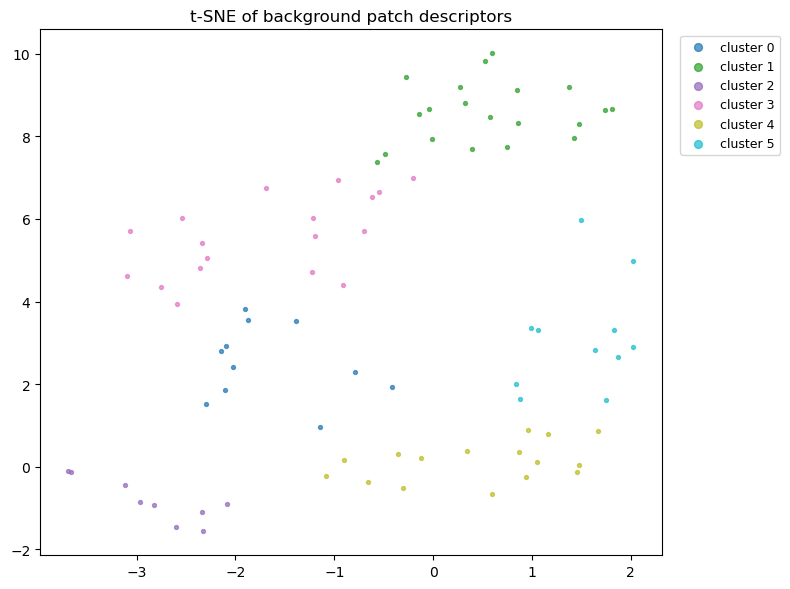

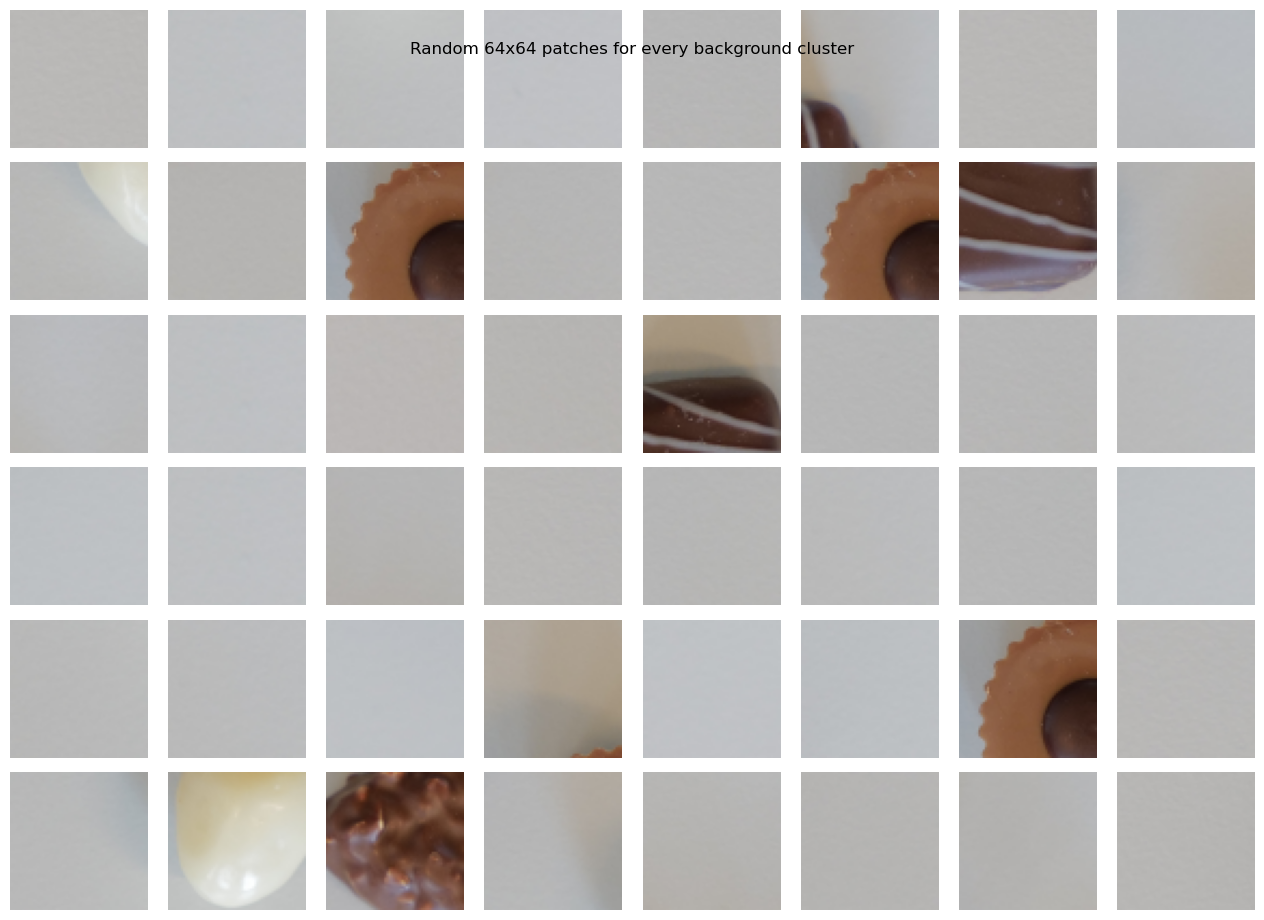

In [18]:
# ---------------------------------------------------------------
#   Visual sanity-check of background clusters
#   (Put this into a notebook cell and execute)
# ---------------------------------------------------------------

from sklearn.manifold import TSNE
import random

# ---------------------------------------------------------------
# 1) Load what we need
#    - descs:   N × 67 float32 (one row per 32×32 patch)
#    - patch_imgs: list[N] of 32×32×3 BGR uint8 patches
#    - bg_model:  pickle with {"mu": [...], "inv": [...]}
# ---------------------------------------------------------------
with open("bg_model.pkl", "rb") as f:
    bg_model = pickle.load(f)

k = len(bg_model["mu"])          # number of clusters (7 in your project)

# ---------------------------------------------------------------
# 2) Assign every descriptor to the nearest μ_k (Mahalanobis)
# ---------------------------------------------------------------
def mahalanobis(x, mu, inv_cov):
    diff = x - mu
    return np.einsum("...i,ij,...j->...", diff, inv_cov, diff)

labels = np.empty(len(bg_desc), dtype=int)
for i, x in enumerate(bg_desc):
    dists = [mahalanobis(x, mu, inv) for mu, inv in
             zip(bg_model["mu"], bg_model["inv"])]
    labels[i] = np.argmin(dists)

# ---------------------------------------------------------------
# 3) 2-D embedding via t-SNE for a qualitative overview
# ---------------------------------------------------------------
print("t-SNE embedding – this may take a minute …")
tsne = TSNE(n_components=2, perplexity=30, init="pca",
            learning_rate="auto", random_state=42)
embed = tsne.fit_transform(bg_desc)            # N × 2

plt.figure(figsize=(8, 6))
cmap = plt.cm.get_cmap("tab10", k)
for kk in range(k):
    idx = labels == kk
    plt.scatter(embed[idx, 0], embed[idx, 1],
                s=8, alpha=0.7, color=cmap(kk), label=f"cluster {kk}")
plt.legend(markerscale=2, fontsize=9, bbox_to_anchor=(1.02, 1))
plt.title("t-SNE of background patch descriptors")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# 4) Random-patch gallery – 8 samples per cluster
# ---------------------------------------------------------------
samples = 8
fig, axes = plt.subplots(k, samples, figsize=(samples*1.6, k*1.6))
for kk in range(k):
    idx = np.flatnonzero(labels == kk)
    chosen = np.random.choice(idx, size=min(samples, len(idx)), replace=False)

    for j, i_patch in enumerate(chosen):
        rgb = cv2.cvtColor(patch_img[i_patch], cv2.COLOR_BGR2RGB)
        ax = axes[kk, j] if k > 1 else axes[j]
        ax.imshow(rgb)
        ax.axis("off")
        if j == 0:
            ax.set_ylabel(f"cl\n{kk}", rotation=0, ha="right", va="center")

# tidy up empty cells if a cluster had < 8 patches
for ax in axes.ravel():
    if not ax.has_data():
        ax.axis("off")

fig.suptitle("Random 64x64 patches for every background cluster", y=0.92)
plt.tight_layout()
plt.show()


## --- TRAINING IMAGES ---

### Test on 1 training image

In [19]:
def preprocessing(bgr, denoise_ksize=5, denoise_sigma=1.0,
                        illum_sigma=60, clahe_clip=1.0, clahe_grid=16,
                        canny_sigma=0.33, se_gap=5, se_close=50, min_area=4000, max_area=500000):
    # 0 — colour to LAB
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab)

    # 1 — Gaussian denoising (small σ)
    L_denoised = cv2.GaussianBlur(L, (denoise_ksize, denoise_ksize), denoise_sigma)

    # 2 — illumination/shadow correction (divide by large-σ blur)
    L32  = L_denoised.astype(np.float32)
    illum = cv2.GaussianBlur(L32, (0, 0), illum_sigma)
    
    L_corr_white = L32 - illum  # white-top-hat
    L_corr_dark = (np.log1p(L32) - np.log1p(np.maximum(illum, 1)))
    L_corr = np.where(np.abs(L_corr_white) > np.abs(L_corr_dark), L_corr_white, L_corr_dark)
    L_corr_norm = cv2.normalize(L_corr, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # mild bilateral to kill desk ripple
    L_corr_norm = cv2.bilateralFilter(L_corr_norm, 9, 12, 12)

    # 3 — CLAHE local contrast
    clahe = cv2.createCLAHE(clipLimit=clahe_clip,
                            tileGridSize=(clahe_grid, clahe_grid))
    L_eq = clahe.apply(L_corr_norm)

    # merge back for visualisation
    lab_eq = cv2.merge((L_eq, A, B))
    bgr_eq = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2BGR)

    # MASK -> EDGE DETECTION
    v = np.median(L_eq)                 # global contrast proxy
    tl = int(max(0, (1.0 - canny_sigma) * v))
    th = int(min(255, (1.0 + canny_sigma) * v))
    edges = cv2.Canny(L_eq, tl, th)
    edges = (edges > 0).astype(np.uint8) * 255

    # thicken the contour and close it
    se_gap = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (se_gap, se_gap))
    edges = cv2.dilate(edges, se_gap, iterations=1)

    se_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (se_close, se_close))
    close_contour = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, se_close, iterations=2)

    # fill interior
    filled = binary_fill_holes(close_contour.astype(bool)).astype(np.uint8) * 255

    # keep only components within size range of a chocolate
    nb, lbl, stats, _ = cv2.connectedComponentsWithStats(filled)
    mask = np.zeros_like(filled)
    for i in range(1, nb):                              # skip background
        area = stats[i, cv2.CC_STAT_AREA]
        if min_area <= area <= max_area:
            mask[lbl == i] = 255

    return bgr_eq, mask

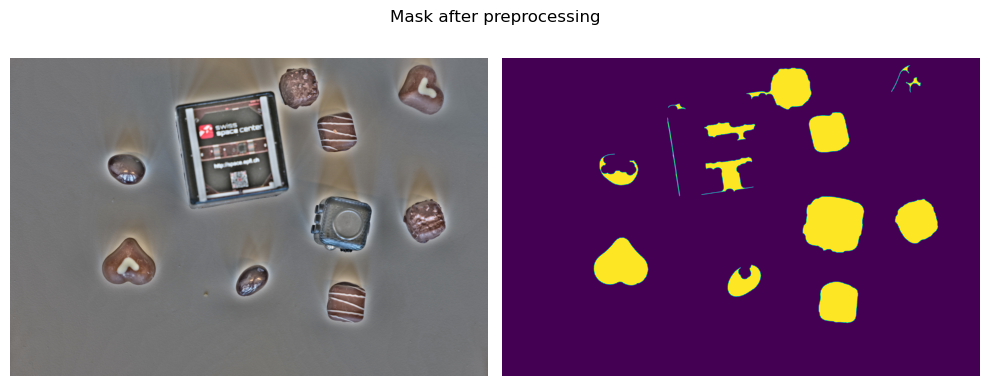

In [20]:
selected_img = train_img[29]

preprocessed_img, edge_mask = preprocessing(selected_img)
plot_image_comparison(preprocessed_img, edge_mask, "Mask after preprocessing")

In [21]:
area_rng, comp_rng = geometric_priors_from_descriptors(all_region_descriptors)
print(area_rng)
print(comp_rng)
obj_candidates = filter_blobs(edge_mask, area_rng, comp_rng)

(20281.275, 411167.075)
(0.13709613023841466, 1.4612756956165702)


In [22]:
areas = [d["area"] for d in all_region_descriptors if "area" in d]
areas_np = np.array(areas)
print(f"area min: {np.min(areas_np)}")
print(f"area max: {np.max(areas_np)}")

area min: 12173.0
area max: 270152.0


In [23]:
print(len(obj_candidates))

9


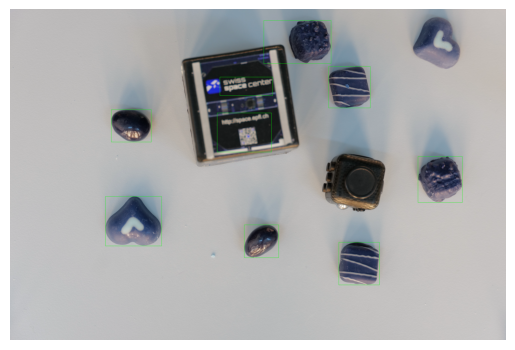

In [24]:
plot_selected_blobs(selected_img, obj_candidates)

In [25]:
# COMPUTE DESCRIPTORS

features = []

for candidate in obj_candidates:
    candidate_mask = candidate["mask"]

    # compute descriptors for each mask
    contour = find_contour_single(candidate_mask)
    region_descr = compute_region_descriptors(candidate_mask)
    fourier_descr = compute_single_descriptor_interpolated(contour, 13)
    color_descr = color_mean_std(selected_img, candidate_mask)
    color_histo = color_hist(selected_img, candidate_mask)
    lbp_histo = lbp_hist(selected_img, candidate_mask)
    combined_vector = np.concatenate([
        [region_descr["area"]],
        [region_descr["rectangularity"]],
        [region_descr["compacity"]],
        [region_descr["elongation"]],
        region_descr["hu_moments"],
        fourier_descr,
        color_descr,
        color_histo,
        lbp_histo
    ])
    candidate["descriptor"] = combined_vector

c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


### ON THE WHOLE DATASET

#### Build object-level x_train_init and labels y_train_init

In [ ]:
def filter_blobs(bin_mask, area_rng, comp_rng):
    """
    Parameters
    ----------
    bin_mask : (H,W) bool/uint8 - foreground mask
    area_rng : (Amin, Amax)
    comp_rng : (Cmin, Cmax)

    Returns
    -------
    candidates : list[dict] - [{'bbox': (minr,minc,maxr,maxc),
                                 'mask': bool array}]
    """
    Amin, Amax = area_rng
    Cmin, Cmax = comp_rng

    lab  = measure.label(bin_mask, connectivity=2)
    candidates = []
    for region in measure.regionprops(lab):
        A = region.area
        if not (Amin <= A <= Amax):
            continue

        P = region.perimeter_crofton
        C = (4 * np.pi * A) / (P ** 2)
        if not (Cmin <= C <= Cmax):
            continue

        r0, c0, r1, c1 = region.bbox
        cand_mask = (lab == region.label)
        candidates.append({"bbox": (r0, c0, r1, c1),
                           "mask": cand_mask})

    return candidates


In [ ]:
# 34 MIN POUR RUN CETTE CELL

from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

x_train_init = []
y_train_init = []
img_counter = 0

# compute for Mahalanobis distance (see below in the for loop)
cov = np.cov(features_ref, rowvar=False)
VI = inv(cov + 1e-6 * np.eye(cov.shape[0]))  # add small value for numerical stability

for img, label in zip(train_img, train_labels):
    img_counter += 1
    print(f"---------- IMAGE NUMBER {img_counter} ----------")

    # 1) preprocessing & foreground mask generation
    img_preprocessed, mask_edge = preprocessing(img)
    print("[info] image preprocessed and mask generated")

    # 2) isolate blobs & identify potential candidates
    obj_candidates = filter_blobs(mask_edge, area_rng, comp_rng)
    print(f"[info] candidates identified: there are {len(obj_candidates)} candidates")

    # 3) for each candidate: compute the descriptors
    features = []
    for candidate in obj_candidates:
        candidate_mask = candidate["mask"]

        # compute descriptors for each mask
        contour = find_contour_single(candidate_mask)
        region_descr = compute_region_descriptors(candidate_mask)
        fourier_descr_complex = compute_single_descriptor_interpolated(contour, 13)
        color_descr = color_mean_std(img, candidate_mask)
        color_histo = color_hist(img, candidate_mask)
        lbp_histo = lbp_hist(img, candidate_mask)
        features_vector = np.concatenate([
            [region_descr["area"]],
            [region_descr["rectangularity"]],
            [region_descr["compacity"]],
            [region_descr["elongation"]],
            region_descr["hu_moments"],
            fourier_descr_complex,
            color_descr,
            color_histo,
            lbp_histo
        ])
        candidate["descriptor"] = features_vector
        features.append(features_vector)

    if not features:
        print("!! FEATURES EMPTY !!")
        continue
    
    stacked_features = np.vstack(features)

    # assign a provisional label by nearest centroid
    dist_matrix = cdist(stacked_features, features_ref, metric='mahalanobis', VI=VI)

    cols, expanded_labels = [], []
    for cls, k in enumerate(label):
        if k == 0:
            continue
        cols.append(np.repeat(dist_matrix[:, [cls]], k, axis=1)) # repeat this chocolate column k times 
        expanded_labels.extend([cls] * k)
    
    cost_matrix = np.hstack(cols) # size: (N_candidates, total_choco_count)
    # Add dummy column (large constant cost) so that surplus blobs can be assigned there instead of being forced to a chocolate
    dummy_cost = np.full((len(stacked_features), 1), cost_matrix.max()*10 + 1)
    cost_matrix = np.hstack([cost_matrix, dummy_cost])
    expanded_labels.append(-1)  # -1 = "junk blob"

    final_labels = np.full(len(stacked_features), -1) # assume by default "none of the candidate are chocolates"
    # correct prediction with Hungarian
    row, col = linear_sum_assignment(cost_matrix)
    for r, c in zip(row, col):
        final_labels[r] = expanded_labels[c]

    for feat, lbl in zip(stacked_features, final_labels):
        if lbl != -1:  # skip junk blobs
            x_train_init.append(feat)
            y_train_init.append(lbl)

---------- IMAGE NUMBER 1 ----------
[info] image preprocessed and mask generated
[info] candidates identified: there are 4 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 2 ----------
[info] image preprocessed and mask generated
[info] candidates identified: there are 4 candidates
---------- IMAGE NUMBER 3 ----------
[info] image preprocessed and mask generated
[info] candidates identified: there are 5 candidates
---------- IMAGE NUMBER 4 ----------
[info] image preprocessed and mask generated
[info] candidates identified: there are 2 candidates
---------- IMAGE NUMBER 5 ----------
[info] image preprocessed and mask generated
[info] candidates identified: there are 1 candidates
---------- IMAGE NUMBER 6 ----------
[info] image preprocessed and mask generated
[info] candidates identified: there are 4 candidates
---------- IMAGE NUMBER 7 ----------
[info] image preprocessed and mask generated
[info] candidates identified: there are 8 candidates
---------- IMAGE NUMBER 8 ----------
[info] image preprocessed and mask generated
[info] candidates identified: there are 1 candidates
---------- IMAGE NUMBER 9 ----------
[info] image prepr

In [32]:
x_train_init = np.array(x_train_init)
print("x_train shape:", x_train_init.shape)
y_train_init = np.array(y_train_init)
print("y_train shape:", y_train_init.shape)

# Check for class balance
classes, counts = np.unique(y_train_init, return_counts=True)
for classe, count in zip(classes,counts):
    print(f"Classe {classe}: {count} samples")

x_train shape: (306, 63)
y_train shape: (306,)
Classe 0: 29 samples
Classe 1: 17 samples
Classe 2: 17 samples
Classe 3: 14 samples
Classe 4: 20 samples
Classe 5: 27 samples
Classe 6: 34 samples
Classe 7: 31 samples
Classe 8: 24 samples
Classe 9: 22 samples
Classe 10: 20 samples
Classe 11: 27 samples
Classe 12: 24 samples


In [33]:
# STANDARDISE THE FEATURE VECTORS

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(x_train_init)
x_train_scaled = scaler.transform(x_train_init)

In [34]:
# SEPARATE SET INTO TRAINING AND VALIDATION SETS

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
    x_train_scaled,
    y_train_init,
    test_size=0.2,
    random_state=42,
    stratify=y_train_init
)

#### Training

In [35]:
# find best k value first

ks = [1, 3, 5, 9, 15, 25]

k, best_accuracy = find_best_k(ks, kNNClassifier, VI, x_train, y_train, x_val, y_val)

print("best k: ", k)
print("best accuracy: ", best_accuracy)

----- K: 1 -----
accuracy  = 0.24193548387096775
----- K: 3 -----
accuracy  = 0.3064516129032258
----- K: 5 -----
accuracy  = 0.25806451612903225
----- K: 9 -----
accuracy  = 0.25806451612903225
----- K: 15 -----
accuracy  = 0.16129032258064516
----- K: 25 -----
accuracy  = 0.16129032258064516
best k:  3
best accuracy:  0.3064516129032258


In [36]:
# find best ood threshold, set it and fit model

kNN, metrics = fit_knn(k, VI, x_train, y_train, x_val, y_val)

per_class_df = pd.DataFrame(metrics["per_class"]).T
print(per_class_df.round(2))

----- WITHOUT OOD REJECTION -----
ood threshold: 7959.350306734828
----- WITH OOD REJECTION -----
     precision  recall  f1-score  support
-1        0.00    0.00      0.00      0.0
 0        0.31    0.67      0.42      6.0
 1        0.25    0.67      0.36      3.0
 2        0.29    0.67      0.40      3.0
 3        0.40    0.67      0.50      3.0
 4        0.33    0.25      0.29      4.0
 5        0.50    0.33      0.40      6.0
 6        0.42    0.71      0.53      7.0
 7        0.00    0.00      0.00      6.0
 8        0.50    0.20      0.29      5.0
 9        0.00    0.00      0.00      4.0
 10       0.00    0.00      0.00      4.0
 11       0.00    0.00      0.00      6.0
 12       0.00    0.00      0.00      5.0


### CROSS-VALIDATION

In [ ]:
#best_kNN = nested_cross_validation(knn, x_train, train_labels, ????? VALIDATION)

## --- TEST PART ---

### Build object-level x_train_init

In [ ]:
def extract_features_from_blob(img, blob_mask):
    contour = find_contour_single(blob_mask)
    region  = compute_region_descriptors(blob_mask)

    fourier = compute_single_descriptor_interpolated(contour, 13)

    color_descr = color_mean_std(img, blob_mask)
    color_histo = color_hist(img, blob_mask)
    lbp_histo = lbp_hist(img, blob_mask)

    features = np.concatenate([
        [region["area"],
         region["rectangularity"],
         region["compacity"],
         region["elongation"]],
        region["hu_moments"],
        fourier,
        color_descr,
        color_histo,
        lbp_histo
    ])
    return features

In [43]:
# TESTING

all_counts = np.zeros((test_img.shape[0], 13), dtype=int)
img_counter_test = 0

for idx, img in enumerate(test_img):
    img_counter_test += 1
    print(f"---------- IMAGE NUMBER {img_counter_test} ----------")
    # 1) preprocessing & foreground mask generation
    img_preproc, edge_mask = preprocessing(img)

    # 2) isolate blobs & identify potential candidates
    obj_candidates = filter_blobs(edge_mask, area_rng, comp_rng)
    print(f"[info] candidates identified: there are {len(obj_candidates)} candidates")

    # 3) for each candidate: compute the descriptors
    features = []
    for candidate in obj_candidates:
        candidate_mask = candidate["mask"]
        features_vector = extract_features_from_blob(img, candidate_mask)
        features.append(features_vector)

    if not features:
        print(f"[warning] no candidates found in image {idx}")
        continue

    # use the SAME SCALER as the one used during training
    features = np.vstack(features) # transform list to np array
    features_scaled = scaler.transform(features)

    # 4) classification
    preds, ood_scores = kNN.predict(features_scaled)

    # 5) counting chocolates
    choc_preds = preds[preds >= 0]        # discard background
    counts = np.bincount(choc_preds, minlength=13)
    all_counts[idx] = counts

---------- IMAGE NUMBER 1 ----------
[info] candidates identified: there are 4 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 2 ----------
[info] candidates identified: there are 2 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 3 ----------
[info] candidates identified: there are 3 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 4 ----------
[info] candidates identified: there are 3 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 5 ----------
[info] candidates identified: there are 2 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 6 ----------
[info] candidates identified: there are 4 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 7 ----------
[info] candidates identified: there are 2 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 8 ----------
[info] candidates identified: there are 1 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 9 ----------
[info] candidates identified: there are 3 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 10 ----------
[info] candidates identified: there are 0 candidates
[warning] no candidates found in image 9
---------- IMAGE NUMBER 11 ----------
[info] candidates identified: there are 2 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 12 ----------
[info] candidates identified: there are 4 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 13 ----------
[info] candidates identified: there are 2 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 14 ----------
[info] candidates identified: there are 2 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 15 ----------
[info] candidates identified: there are 4 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 16 ----------
[info] candidates identified: there are 5 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 17 ----------
[info] candidates identified: there are 4 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 18 ----------
[info] candidates identified: there are 3 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 19 ----------
[info] candidates identified: there are 5 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 20 ----------
[info] candidates identified: there are 3 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 21 ----------
[info] candidates identified: there are 2 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 22 ----------
[info] candidates identified: there are 5 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 23 ----------
[info] candidates identified: there are 2 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 24 ----------
[info] candidates identified: there are 4 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 25 ----------
[info] candidates identified: there are 7 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 26 ----------
[info] candidates identified: there are 0 candidates
[warning] no candidates found in image 25
---------- IMAGE NUMBER 27 ----------
[info] candidates identified: there are 4 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 28 ----------
[info] candidates identified: there are 4 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 29 ----------
[info] candidates identified: there are 6 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 30 ----------
[info] candidates identified: there are 0 candidates
[warning] no candidates found in image 29
---------- IMAGE NUMBER 31 ----------
[info] candidates identified: there are 2 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 32 ----------
[info] candidates identified: there are 3 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 33 ----------
[info] candidates identified: there are 4 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 34 ----------
[info] candidates identified: there are 6 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 35 ----------
[info] candidates identified: there are 5 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 36 ----------
[info] candidates identified: there are 4 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 37 ----------
[info] candidates identified: there are 3 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 38 ----------
[info] candidates identified: there are 4 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 39 ----------
[info] candidates identified: there are 6 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 40 ----------
[info] candidates identified: there are 4 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 41 ----------
[info] candidates identified: there are 3 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 42 ----------
[info] candidates identified: there are 4 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 43 ----------
[info] candidates identified: there are 5 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 44 ----------
[info] candidates identified: there are 3 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 45 ----------
[info] candidates identified: there are 6 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 46 ----------
[info] candidates identified: there are 2 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 47 ----------
[info] candidates identified: there are 2 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 48 ----------
[info] candidates identified: there are 6 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 49 ----------
[info] candidates identified: there are 4 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 50 ----------
[info] candidates identified: there are 8 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 51 ----------
[info] candidates identified: there are 2 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 52 ----------
[info] candidates identified: there are 1 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 53 ----------
[info] candidates identified: there are 2 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 54 ----------
[info] candidates identified: there are 2 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 55 ----------
[info] candidates identified: there are 9 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 56 ----------
[info] candidates identified: there are 0 candidates
[warning] no candidates found in image 55
---------- IMAGE NUMBER 57 ----------
[info] candidates identified: there are 4 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 58 ----------
[info] candidates identified: there are 9 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 59 ----------
[info] candidates identified: there are 2 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 60 ----------
[info] candidates identified: there are 6 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 61 ----------
[info] candidates identified: there are 3 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 62 ----------
[info] candidates identified: there are 1 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 63 ----------
[info] candidates identified: there are 3 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 64 ----------
[info] candidates identified: there are 3 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 65 ----------
[info] candidates identified: there are 4 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 66 ----------
[info] candidates identified: there are 10 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 67 ----------
[info] candidates identified: there are 9 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 68 ----------
[info] candidates identified: there are 7 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 69 ----------
[info] candidates identified: there are 0 candidates
[warning] no candidates found in image 68
---------- IMAGE NUMBER 70 ----------
[info] candidates identified: there are 0 candidates
[warning] no candidates found in image 69
---------- IMAGE NUMBER 71 ----------
[info] candidates identified: there are 0 candidates
[warning] no candidates found in image 70
---------- IMAGE NUMBER 72 ----------
[info] candidates identified: there are 2 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 73 ----------
[info] candidates identified: there are 3 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 74 ----------
[info] candidates identified: there are 3 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 75 ----------
[info] candidates identified: there are 3 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 76 ----------
[info] candidates identified: there are 2 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 77 ----------
[info] candidates identified: there are 2 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 78 ----------
[info] candidates identified: there are 1 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 79 ----------
[info] candidates identified: there are 1 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 80 ----------
[info] candidates identified: there are 4 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 81 ----------
[info] candidates identified: there are 5 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 82 ----------
[info] candidates identified: there are 3 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 83 ----------
[info] candidates identified: there are 2 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 84 ----------
[info] candidates identified: there are 13 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 85 ----------
[info] candidates identified: there are 10 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 86 ----------
[info] candidates identified: there are 10 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 87 ----------
[info] candidates identified: there are 1 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 88 ----------
[info] candidates identified: there are 0 candidates
[warning] no candidates found in image 87
---------- IMAGE NUMBER 89 ----------
[info] candidates identified: there are 0 candidates
[warning] no candidates found in image 88
---------- IMAGE NUMBER 90 ----------
[info] candidates identified: there are 6 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 91 ----------
[info] candidates identified: there are 5 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 92 ----------
[info] candidates identified: there are 3 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 93 ----------
[info] candidates identified: there are 3 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 94 ----------
[info] candidates identified: there are 2 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 95 ----------
[info] candidates identified: there are 3 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 96 ----------
[info] candidates identified: there are 3 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 97 ----------
[info] candidates identified: there are 1 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 98 ----------
[info] candidates identified: there are 1 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 99 ----------
[info] candidates identified: there are 1 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 100 ----------
[info] candidates identified: there are 0 candidates
[warning] no candidates found in image 99
---------- IMAGE NUMBER 101 ----------
[info] candidates identified: there are 3 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 102 ----------
[info] candidates identified: there are 4 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 103 ----------
[info] candidates identified: there are 4 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 104 ----------
[info] candidates identified: there are 9 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 105 ----------
[info] candidates identified: there are 8 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 106 ----------
[info] candidates identified: there are 6 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 107 ----------
[info] candidates identified: there are 0 candidates
[warning] no candidates found in image 106
---------- IMAGE NUMBER 108 ----------
[info] candidates identified: there are 1 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 109 ----------
[info] candidates identified: there are 1 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 110 ----------
[info] candidates identified: there are 1 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 111 ----------
[info] candidates identified: there are 3 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 112 ----------
[info] candidates identified: there are 5 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 113 ----------
[info] candidates identified: there are 2 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 114 ----------
[info] candidates identified: there are 7 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 115 ----------
[info] candidates identified: there are 8 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 116 ----------
[info] candidates identified: there are 6 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 117 ----------
[info] candidates identified: there are 12 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 118 ----------
[info] candidates identified: there are 0 candidates
[warning] no candidates found in image 117
---------- IMAGE NUMBER 119 ----------
[info] candidates identified: there are 2 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 120 ----------
[info] candidates identified: there are 1 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 121 ----------
[info] candidates identified: there are 2 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 122 ----------
[info] candidates identified: there are 2 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 123 ----------
[info] candidates identified: there are 2 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 124 ----------
[info] candidates identified: there are 4 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 125 ----------
[info] candidates identified: there are 7 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 126 ----------
[info] candidates identified: there are 8 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 127 ----------
[info] candidates identified: there are 6 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 128 ----------
[info] candidates identified: there are 2 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 129 ----------
[info] candidates identified: there are 0 candidates
[warning] no candidates found in image 128
---------- IMAGE NUMBER 130 ----------
[info] candidates identified: there are 1 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 131 ----------
[info] candidates identified: there are 1 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 132 ----------
[info] candidates identified: there are 4 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 133 ----------
[info] candidates identified: there are 1 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 134 ----------
[info] candidates identified: there are 2 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 135 ----------
[info] candidates identified: there are 0 candidates
[warning] no candidates found in image 134
---------- IMAGE NUMBER 136 ----------
[info] candidates identified: there are 0 candidates
[warning] no candidates found in image 135
---------- IMAGE NUMBER 137 ----------
[info] candidates identified: there are 0 candidates
[warning] no candidates found in image 136
---------- IMAGE NUMBER 138 ----------
[info] candidates identified: there are 0 candidates
[warning] no candidates found in image 137
---------- IMAGE NUMBER 139 ----------
[info] candidates identified: there are 1 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 140 ----------
[info] candidates identified: there are 0 candidates
[warning] no candidates found in image 139
---------- IMAGE NUMBER 141 ----------
[info] candidates identified: there are 1 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 142 ----------
[info] candidates identified: there are 3 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 143 ----------
[info] candidates identified: there are 1 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 144 ----------
[info] candidates identified: there are 3 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 145 ----------
[info] candidates identified: there are 5 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 146 ----------
[info] candidates identified: there are 2 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 147 ----------
[info] candidates identified: there are 1 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 148 ----------
[info] candidates identified: there are 0 candidates
[warning] no candidates found in image 147
---------- IMAGE NUMBER 149 ----------
[info] candidates identified: there are 0 candidates
[warning] no candidates found in image 148
---------- IMAGE NUMBER 150 ----------
[info] candidates identified: there are 0 candidates
[warning] no candidates found in image 149
---------- IMAGE NUMBER 151 ----------
[info] candidates identified: there are 5 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 152 ----------
[info] candidates identified: there are 5 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 153 ----------
[info] candidates identified: there are 2 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 154 ----------
[info] candidates identified: there are 3 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 155 ----------
[info] candidates identified: there are 8 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 156 ----------
[info] candidates identified: there are 2 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 157 ----------
[info] candidates identified: there are 7 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 158 ----------
[info] candidates identified: there are 0 candidates
[warning] no candidates found in image 157
---------- IMAGE NUMBER 159 ----------
[info] candidates identified: there are 0 candidates
[warning] no candidates found in image 158
---------- IMAGE NUMBER 160 ----------
[info] candidates identified: there are 2 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 161 ----------
[info] candidates identified: there are 1 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 162 ----------
[info] candidates identified: there are 3 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 163 ----------
[info] candidates identified: there are 3 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 164 ----------
[info] candidates identified: there are 12 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 165 ----------
[info] candidates identified: there are 6 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 166 ----------
[info] candidates identified: there are 6 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 167 ----------
[info] candidates identified: there are 1 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 168 ----------
[info] candidates identified: there are 2 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 169 ----------
[info] candidates identified: there are 5 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 170 ----------
[info] candidates identified: there are 3 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 171 ----------
[info] candidates identified: there are 5 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 172 ----------
[info] candidates identified: there are 4 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 173 ----------
[info] candidates identified: there are 7 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 174 ----------
[info] candidates identified: there are 8 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 175 ----------
[info] candidates identified: there are 4 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 176 ----------
[info] candidates identified: there are 13 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 177 ----------
[info] candidates identified: there are 0 candidates
[warning] no candidates found in image 176
---------- IMAGE NUMBER 178 ----------
[info] candidates identified: there are 1 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 179 ----------
[info] candidates identified: there are 1 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


---------- IMAGE NUMBER 180 ----------
[info] candidates identified: there are 2 candidates


c:\Users\nnaro\anaconda3\envs\romane_IAPR_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [44]:
# PREPARE SUBMISSION

sub_file = "./dataset/sample_submission.csv"
create_submission(sub_file, all_counts)

template shape: (180, 14)
✓  submission.csv written
